**Kwaku Amo-Korankye - 10211100331<br>Class of 2025: Bachelor of Science in Artificial Intelligence<br>Explainability using GradCAM**

In [1]:
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2
import os
from PIL import Image
import numpy as np
from torchvision.models.resnet import ResNet
from torch.serialization import add_safe_globals
import matplotlib.pyplot as plt

/opt/anaconda3/lib/python3.12/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [13]:
# Define class labels
classes = ['glioma', 'healthy', 'meningioma', 'pituitary']

# Define image transformations (same as validation set)
transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

# # Add ResNet to safe globals before loading
# add_safe_globals([ResNet])

# Load the trained model
brain_tumor_model = torch.load("/Users/academiccity/Documents/amokorankye/models/saved models/brain_tumor_model.pth", weights_only=False )
brain_tumor_model.eval()  # Set to evaluation mode

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [14]:
def predict(image_path):
    """
    Predict brain tumor classification for multiple image types
    Supports: jpg, jpeg, png, bmp, tiff
    """
    # Supported image extensions
    SUPPORTED_FORMATS = {'.jpg', '.jpeg', '.png', '.bmp', '.tiff'}
    
    try:
        # Validate file extension
        file_ext = os.path.splitext(image_path)[1].lower()
        if file_ext not in SUPPORTED_FORMATS:
            raise ValueError(f"Unsupported image format. Supported formats: {', '.join(SUPPORTED_FORMATS)}")

        # Load image using PIL first (handles multiple formats better)
        pil_image = Image.open(image_path)
        
        # Convert to RGB if needed
        if pil_image.mode != 'RGB':
            pil_image = pil_image.convert('RGB')
            
        # Convert to numpy array for albumentations
        image = np.array(pil_image)
        
        # Apply transformations
        transformed = transform(image=image)
        image_tensor = transformed["image"].unsqueeze(0)

        # Move tensor to same device as model
        device = next(brain_tumor_model.parameters()).device
        image_tensor = image_tensor.to(device)

        # Perform inference
        with torch.no_grad():
            output = brain_tumor_model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            probabilities = torch.nn.functional.softmax(output, dim=1)
            confidence = probabilities[0, predicted_class].item()

        # Return detailed results
        result = {
            'diagnosis': classes[predicted_class],
            'confidence': confidence,
            'probabilities': {
                classes[i]: probabilities[0, i].item() 
                for i in range(len(classes))
            }
        }
        
        # Print formatted results
        print(f"\nDiagnosis Results:")
        print(f"================")
        print(f"Classification: {result['diagnosis']}")
        print(f"Confidence: {result['confidence']:.2%}")
        print(f"\nClass Probabilities:")
        for cls, prob in result['probabilities'].items():
            print(f"{cls}: {prob:.2%}")
            
        return result

    except FileNotFoundError:
        print(f"Error: Image file '{image_path}' not found")
        return None
    except Exception as e:
        print(f"Error processing image: {str(e)}")
        return None

In [15]:
# Example usage
image_path = "/Users/academiccity/Documents/amokorankye/models/saved models/test images/glioma.jpg"  # Replace with your image file
predict(image_path)


Diagnosis Results:
Classification: glioma
Confidence: 99.98%

Class Probabilities:
glioma: 99.98%
healthy: 0.00%
meningioma: 0.01%
pituitary: 0.01%


{'diagnosis': 'glioma',
 'confidence': 0.9997852444648743,
 'probabilities': {'glioma': 0.9997852444648743,
  'healthy': 6.139827064544079e-07,
  'meningioma': 7.123900286387652e-05,
  'pituitary': 0.00014287701924331486}}

In [16]:
def apply_gradcam(image_path, model=brain_tumor_model, target_layer=brain_tumor_model.layer4[-1]):
    # Set up GradCAM
    class GradCAM:
        def __init__(self, model, target_layer):
            self.model = model
            self.target_layer = target_layer
            self.gradients = None
            self.features = None
            
            # Register hooks
            self.target_layer.register_forward_hook(self.save_features)
            self.target_layer.register_full_backward_hook(self.save_gradients)
        
        def save_features(self, module, input, output):
            self.features = output
            
        def save_gradients(self, module, grad_input, grad_output):
            self.gradients = grad_output[0]
            
        def generate(self, input_image):
            # Forward pass
            model_output = self.model(input_image)
            predicted_class = torch.argmax(model_output)
            
            # Backward pass
            model_output[:, predicted_class].backward()
            
            # Generate CAM
            pooled_gradients = torch.mean(self.gradients, dim=[0, 2, 3])
            for i in range(self.features.shape[1]):
                self.features[:, i, :, :] *= pooled_gradients[i]
            
            cam = torch.mean(self.features, dim=1).squeeze()
            cam = torch.maximum(cam, torch.zeros_like(cam))  # ReLU
            cam = (cam - cam.min()) / (cam.max() - cam.min())  # Normalize
            
            return cam.detach(), predicted_class  # Detach here

    try:
        # Load and preprocess image
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        original_size = image.shape[:2]
        
        # Apply transformations
        transformed = transform(image=image)
        input_tensor = transformed["image"].unsqueeze(0)
        
        # Initialize GradCAM
        grad_cam = GradCAM(model, target_layer)
        
        # Generate heatmap
        cam, predicted_class = grad_cam.generate(input_tensor)
        cam = cam.cpu().numpy()
        cam = cv2.resize(cam, (original_size[1], original_size[0]))
        
        # Create heatmap overlay
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)
        
        # Combine original image with heatmap
        alpha = 0.5
        superimposed = cv2.addWeighted(image, alpha, heatmap, 1-alpha, 0)
        
        # Display results
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        ax1.imshow(image)
        ax1.set_title('Original Image')
        ax1.axis('off')
        
        ax2.imshow(heatmap)
        ax2.set_title('GradCAM Heatmap')
        ax2.axis('off')
        
        ax3.imshow(superimposed)
        ax3.set_title('Superimposed')
        ax3.axis('off')
        
        plt.suptitle(f'Predicted Class: {classes[predicted_class]}')
        plt.tight_layout()
        plt.show()
        
        return cam
        
    except Exception as e:
        print(f"Error applying GradCAM: {str(e)}")
        return None

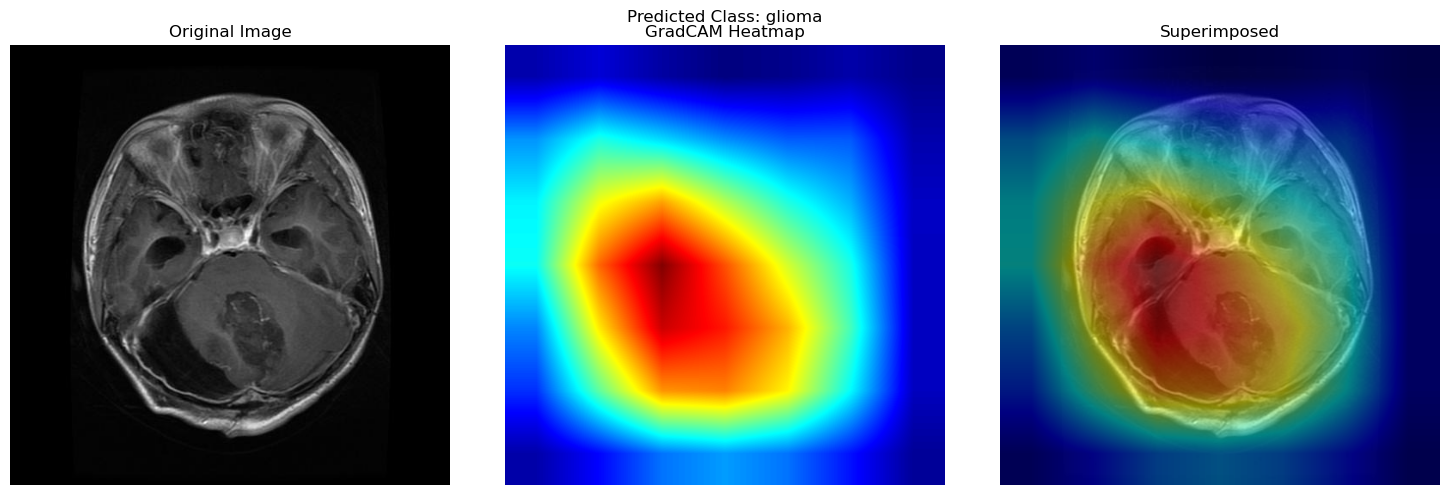


Diagnosis Results:
Classification: glioma
Confidence: 99.98%

Class Probabilities:
glioma: 99.98%
healthy: 0.00%
meningioma: 0.01%
pituitary: 0.01%


{'diagnosis': 'glioma',
 'confidence': 0.9997852444648743,
 'probabilities': {'glioma': 0.9997852444648743,
  'healthy': 6.139827064544079e-07,
  'meningioma': 7.123900286387652e-05,
  'pituitary': 0.00014287701924331486}}

In [17]:
apply_gradcam(image_path, model=brain_tumor_model, target_layer=brain_tumor_model.layer4[-1])
predict(image_path)

In [ ]:
from transformers import BioGptForCausalLM, AutoTokenizer

# Load model and tokenizer
model_name = "microsoft/biogpt"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = BioGptForCausalLM.from_pretrained(model_name)

# Example input prompt for medical report generation
input_text = """
Patient MRI shows signs of glioma. The diagnosis suggests the following diagnosis results
Diagnosis Results:
================
Classification: glioma
Confidence: 99.98%

Class Probabilities:
glioma: 99.98%
healthy: 0.00%
meningioma: 0.01%
pituitary: 0.01%
"""
inputs = tokenizer(input_text, return_tensors="pt")

# Generate medical text
output = model.generate(**inputs, max_length=250, temperature=0.7, top_k=50)
generated_text = tokenizer.decode(output[0], skip_special_tokens=True)

print("Generated Report:\n", generated_text)


pytorch_model.bin:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.56G [00:00<?, ?B/s]

Generated Report:
 Patient MRI shows signs of glioma. The diagnosis suggests the following diagnosis results Diagnosis Results: = = = = = = = = = = = = = = = = Classification: glioma Confidence: 99.98% Class Probabilities: glioma: 99.98% healthy: 0.00% meningioma: 0.01% pituitary: 0.01% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% meningioma: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% meningioma: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary: 0.00% pituitary
